# State 정의하기

In [ ]:
import operator
from typing import TypedDict, Annotated, List, Optional, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import json
from langgraph.checkpoint.memory import MemorySaver

# Agent가 채워 넣어야 할 데이터 구조 정의
# --- 1. Agent 1 데이터 스키마 (TripPreferences) ---
class TripPreferences(BaseModel):
    # 1. 기간
    duration: str = Field(
        None,
        description="여행 기간. 예: '1일', '2일', '3일' 등. 몇 박 묵을지는 궁금하지 않다. 명시되지 않으면 None."
    )

    # 2. 테마 (여러 개일 수 있으니 List로)
    themes: List[Literal['맛집', '쇼핑', '문화/예술', '힐링', '체험', '뷰/야경', '트렌드']] = Field(
        default_factory=list,
        description="여행 테마 리스트. 예: ['맛집', '쇼핑', '문화/예술', '힐링', '체험', '뷰/야경', '트렌드']"
    )

    # 3. 강도 (숫자로 변환)
    intensity: int = Field(
        None,
        description="여행 강도 (0~100). 0은 완전한 휴식, 100은 빡빡한 일정. 강도를 단순히 0, 50, 100으로 나누지 말고, 사용자의 입력에 대해서 적절한 값으로 반환합니다. 정보가 없으면 None"
    )
    
    # 4. 동행자
    companions: Optional[Literal['혼자', '친구', '연인', '가족(아이)', '가족(부모님)']] = Field(
        None,
        description="동행자 유형. 예: '혼자', '친구', '연인', '가족(아이)', '가족(부모님)'. 정보가 없으면 None"
    )
    
    # 5. 이동 방식
    transport: Optional[Literal['대중교통', '도보', '차량']] = Field(
        None,
        description="이동 수단 선호. 예: '대중교통', '도보', '차량'. 정보가 없으면 None"
    )
    
    # 6. HITL 필수 필드 (대화 제어용)
    is_complete: bool = Field(
        False,
        description="위 5가지 필수 정보(duration, themes, intensity, companions, transport)가 모두 채워졌는지 여부."
    )
    
    # 부족한 부분을 채우기 위한 질문지
    missing_info_question: Optional[str] = Field(
        None, 
        description="정보가 부족할 경우 사용자에게 던질 질문. (부족한 항목을 콕 집어서 질문)"
    )

    # 7. 기타 (혹시 모를 추가 요청사항)
    additional_notes: Optional[str] = Field(
        None,
        description="위 카테고리에 없는 기타 요구사항 혹은 카테고리 내용을 요약 정리해서 추가합니다. 누구와 얼마만큼의 기간동안 어떤 테마들을 기준으로 어느 정도의 강도로 무엇을 타고 여행을 할 지 작성해줍니다."
    )


class AgentState(TypedDict):
    # 입력: 사용자의 질문
    messages: Annotated[List[BaseMessage], operator.add]

    # 출력: Agent 1이 채워넣을 분석 결과 (초기에는 None일 수 있음)
    preferences: TripPreferences

# Node 만들기

In [104]:
def planner_node(state: AgentState):
    print("\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---")
    
    # 2. LLM 설정 (구조화된 출력)
    llm = ChatOpenAI(model='gpt-4o', temperature=0)
    structured_llm = llm.with_structured_output(TripPreferences)

    # 현재 상태 가져오기
    current_pref = state.get("preferences", TripPreferences())

    # 시스템 프롬프트: "5가지가 다 모여야 탈출 가능"
    system_prompt = f"""
    당신은 한국어, 영어, 일본어, 중국어에 모두 능통한 '베테랑 여행 플래너'입니다.
    사용자의 입력과 대화 내역을 분석하여 여행 정보를 추출하세요.
    
    [현재 파악된 정보]
    {json.dumps(current_pref.model_dump(), indent=2, ensure_ascii=False)}
    
    [필수 확보 정보 (5-Check)]
    여행 계획을 짜기 위해 다음 5가지 정보는 **반드시** 값이 있어야 합니다.
    1. duration (기간)
    2. themes (테마 - 최소 1개 이상)
    3. intensity (여행 강도)
    4. companions (동행자)
    5. transport (이동 수단)
    
    [언어 처리 규칙 (매우 중요)]
    1. **언어 감지**: 사용자가 입력한 언어(한/영/일/중)를 감지하세요.
    2. **데이터 매핑 (Internal)**: 사용자가 외국어로 말하더라도, 추출하는 값은 반드시 스키마에 정의된 **'한국어 표준 값'**으로 변환하여 저장하세요.
       - 예: User "I want to go shopping" -> themes=['쇼핑'] (NOT 'Shopping')
       - 예: User "電車で行きます (전철로 갈래요)" -> transport='대중교통'
    3. **질문 생성 (External)**: `missing_info_question`은 반드시 **사용자가 입력한 언어**로 작성하세요.
       - 예: 사용자가 일본어로 말했으면, 질문도 일본어로 생성.
    
    [지시사항]
    - 위 5가지 중 하나라도 값이 없거나(None), 빈 리스트라면 'is_complete'는 False입니다.
    - 'is_complete'가 False라면, 부족한 정보가 무엇인지 파악하여 사용자에게 자연스럽게 물어보는 질문을 'missing_info_question'에 작성하세요.
    - **질문은 친절하고 정중한 톤을 유지하세요.**
    - 모든 정보가 채워졌을 때만 'is_complete'를 True로 설정하세요.
    """

    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    
    result = structured_llm.invoke(messages)
    
    return {"preferences": result}

In [105]:
# def planner_node(state: AgentState):
#     print("--- [Agent 1] 사용자 의도 분석 중. . . ---")

#     # 1. State에서 사용자 입력 꺼내기
#     user_input = state['user_input']
    
#     # 2. LLM 설정 (구조화된 출력)
#     llm = ChatOpenAI(model='gpt-4o', temperature=0)
#     structured_llm = llm.with_structured_output(TripPreferences)

#     # 3. 프롬프트 및 실행
#     system_prompt = "너는 사용자의 입력에 따라서 출력을 기획하는 기획자야. 사용자 입력을 분석해"
#     prompt = ChatPromptTemplate.from_messages([
#         ("system", system_prompt),
#         ("human", "{text}"),
#     ])

#     chain = prompt | structured_llm
#     print(chain)
#     result = chain.invoke({"text": user_input})

#     # 4. 결과 반환 (State를 어떻게 업데이트할지 리턴)
#     # 여기서 리턴한 딕셔너리가 기존 State에 덮어씌워짐(Update)
#     return {"preferences": result}

# Graph로 만들기

In [115]:
from langgraph.graph import StateGraph, END, START

# 1) 그래프 초기화 (어떤 State를 사용할 건지 결정)
workflow = StateGraph(AgentState)

# 2) 노드 등록
# "planner"라는 이름표를 붙여서 planner_node 함수를 등록
workflow.add_node("planner", planner_node)

# 3) 엣지 연결 (순서 정의)
# workflow.add_edge(START, "process")
workflow.set_entry_point("planner")
workflow.add_edge("planner", END)
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# 그래프 그리기

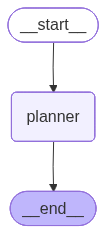

In [116]:
# 그래프 그리기
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# 테스트 진행

In [ ]:
import time
if __name__ == "__main__":
    print("🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)")

    # config 설정 (이게 있어야 기억이 유지됨)
    config = {"configurable": {"thread_id": "1"}}

    current_prefs = TripPreferences()
    chat_history = []
    
    while True:
        user_input = input("\n👤 유저: ")
        if user_input.lower() == 'q': break
        
        # 상태 주입
        inputs = {
            "messages": [HumanMessage(content=user_input)],
            "preferences": current_prefs
        }
        
        # 실행
        result_state = app.invoke(inputs, config=config)
        print(result_state)
        current_prefs = result_state['preferences']
        
        # 검증 로직
        if current_prefs.is_complete:
            print(f"\n✅ [모든 정보 확보 완료]")
            print(f"기간: {current_prefs.duration}")
            print(f"동행: {current_prefs.companions}")
            print(f"테마: {current_prefs.themes}")
            print(f"강도: {current_prefs.intensity}")
            print(f"이동: {current_prefs.transport}")
            print(f"기타: {current_prefs.additional_notes}")
            break
        else:
            # 질문 출력
            print(f"🤖 Agent: {current_prefs.missing_info_question}")
            time.sleep(1)
            # (디버깅용: 현재 채워진 정보 확인)
            print(f"(Debug) 현재 상태: {current_prefs.model_dump(exclude={'missing_info_question', 'is_complete'})}")

🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='友達と2泊3日でソウル旅行に行くよ。', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=[], intensity=50, companions='친구', transport=None, is_complete=False, missing_info_question='どのような移動手段を考えていますか？また、旅行のテーマは何ですか？', additional_notes='사용자가 친구와 함께 2박 3일 동안 서울 여행을 계획하고 있습니다. 여행 강도는 보통으로 설정했습니다.')}
🤖 Agent: どのような移動手段を考えていますか？また、旅行のテーマは何ですか？
(Debug) 현재 상태: {'duration': '3일', 'themes': [], 'intensity': 50, 'companions': '친구', 'transport': None, 'additional_notes': '사용자가 친구와 함께 2박 3일 동안 서울 여행을 계획하고 있습니다. 여행 강도는 보통으로 설정했습니다.'}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='友達と2泊3日でソウル旅行に行くよ。', additional_kwargs={}, response_metadata={}), HumanMessage(content='昼はカフェや美味しいお店を巡って、夜は夜景を見ながら一杯やりたいな', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경'], intensity=

In [ ]:
"""
"\n🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=[], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요?', additional_notes=None)}\n🤖 Agent: 어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요?\n(Debug) 현재 상태: {'duration': '3일', 'themes': [], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': None}\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경'], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?', additional_notes='낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심.')}\n🤖 Agent: 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?\n(Debug) 현재 상태: {'duration': '3일', 'themes': ['맛집', '뷰/야경'], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': '낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심.'}\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={}), HumanMessage(content='여자친구랑 여행 갈거고, 관광지도 좀 둘러보고 싶네!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경', '문화/예술'], intensity=0, companions='연인', transport=None, is_complete=False, missing_info_question='이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?', additional_notes='낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.')}\n🤖 Agent: 이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?\n(Debug) 현재 상태: {'duration': '3일', 'themes': ['맛집', '뷰/야경', '문화/예술'], 'intensity': 0, 'companions': '연인', 'transport': None, 'additional_notes': '낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.'}\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={}), HumanMessage(content='여자친구랑 여행 갈거고, 관광지도 좀 둘러보고 싶네!', additional_kwargs={}, response_metadata={}), HumanMessage(content='차를 빌리거나 할것 같아. 빌리지 못한다면 대중교통을 타야겠지. 여자친구랑 다니는 거니까 적당히 걷기도 하고, 약간 빡빡하게 하기도 하려고', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경', '문화/예술'], intensity=50, companions='연인', transport='대중교통', is_complete=True, missing_info_question=None, additional_notes='낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.')}\n\n✅ [모든 정보 확보 완료]\n기간: 3일\n동행: 연인\n테마: ['맛집', '뷰/야경', '문화/예술']\n강도: 50\n이동: 대중교통\n기타: 낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.\n"
🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content="I'm thinking about 3 days of plan. This is my first trip of seoul, and also solo trip ever! I love walking so I think use some transports and walking. ", additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=[], intensity=50, companions='혼자', transport='대중교통', is_complete=False, missing_info_question='What kind of activities or themes are you interested in for your trip? For example, food, shopping, culture, or something else?', additional_notes='The user is planning a 3-day solo trip to Seoul and prefers walking and using public transport. This is their first trip to Seoul.')}
🤖 Agent: What kind of activities or themes are you interested in for your trip? For example, food, shopping, culture, or something else?
(Debug) 현재 상태: {'duration': '3일', 'themes': [], 'intensity': 50, 'companions': '혼자', 'transport': '대중교통', 'additional_notes': 'The user is planning a 3-day solo trip to Seoul and prefers walking and using public transport. This is their first trip to Seoul.'}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content="I'm thinking about 3 days of plan. This is my first trip of seoul, and also solo trip ever! I love walking so I think use some transports and walking. ", additional_kwargs={}, response_metadata={}), HumanMessage(content='I love sightseeing! and eating some food. as you know. haha korea is famouse for K-food!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['뷰/야경', '맛집'], intensity=50, companions='혼자', transport='대중교통', is_complete=True, missing_info_question=None, additional_notes='The user is planning a 3-day solo trip to Seoul and prefers walking and using public transport. This is their first trip to Seoul. They are interested in sightseeing and trying Korean food.')}

✅ [모든 정보 확보 완료]
기간: 3일
동행: 혼자
테마: ['뷰/야경', '맛집']
강도: 50
이동: 대중교통
기타: The user is planning a 3-day solo trip to Seoul and prefers walking and using public transport. This is their first trip to Seoul. They are interested in sightseeing and trying Korean food.
"""

In [109]:
"""
🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='2박 3일', themes=[], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하시나요? 이동 수단은 어떻게 계획하고 계신가요?', additional_notes=None)}
🤖 Agent: 어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하시나요? 이동 수단은 어떻게 계획하고 계신가요?
(Debug) 현재 상태: {'duration': '2박 3일', 'themes': [], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': None}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='2박 3일', themes=['맛집', '뷰/야경'], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='누구와 함께 여행하시나요? 이동 수단은 어떻게 계획하고 계신가요?', additional_notes='낮에는 카페와 맛집을 방문하고, 밤에는 야경을 보며 와인을 즐기고 싶어합니다.')}
🤖 Agent: 누구와 함께 여행하시나요? 이동 수단은 어떻게 계획하고 계신가요?
(Debug) 현재 상태: {'duration': '2박 3일', 'themes': ['맛집', '뷰/야경'], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': '낮에는 카페와 맛집을 방문하고, 밤에는 야경을 보며 와인을 즐기고 싶어합니다.'}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={}), HumanMessage(content='친구들이랑 갈거고, 관광지도 좀 둘러보고 싶네!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='2박 3일', themes=['맛집', '뷰/야경', '문화/예술'], intensity=0, companions='친구', transport=None, is_complete=False, missing_info_question='이동 수단은 어떻게 계획하고 계신가요?', additional_notes='낮에는 카페와 맛집을 방문하고, 밤에는 야경을 보며 와인을 즐기고 싶어하며, 친구들과 함께 관광지를 둘러보고 싶어합니다.')}
🤖 Agent: 이동 수단은 어떻게 계획하고 계신가요?
(Debug) 현재 상태: {'duration': '2박 3일', 'themes': ['맛집', '뷰/야경', '문화/예술'], 'intensity': 0, 'companions': '친구', 'transport': None, 'additional_notes': '낮에는 카페와 맛집을 방문하고, 밤에는 야경을 보며 와인을 즐기고 싶어하며, 친구들과 함께 관광지를 둘러보고 싶어합니다.'}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={}), HumanMessage(content='친구들이랑 갈거고, 관광지도 좀 둘러보고 싶네!', additional_kwargs={}, response_metadata={}), HumanMessage(content='차를 빌리거나 할것 같아. 빌리지 못한다면 대중교통을 타야겠지. 여자친구랑 다니는 거니까 적당히 걷기도 하고, 약간 빡빡하게 하기도 하려고', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='2박 3일', themes=['맛집', '뷰/야경', '문화/예술'], intensity=50, companions='친구', transport='차량', is_complete=True, missing_info_question=None, additional_notes='낮에는 카페와 맛집을 방문하고, 밤에는 야경을 보며 와인을 즐기고 싶어하며, 친구들과 함께 관광지를 둘러보고 싶어합니다.')}

✅ [모든 정보 확보 완료]
기간: 2박 3일
동행: 친구
테마: ['맛집', '뷰/야경', '문화/예술']
강도: 50
이동: 차량
기타: 낮에는 카페와 맛집을 방문하고, 밤에는 야경을 보며 와인을 즐기고 싶어하며, 친구들과 함께 관광지를 둘러보고 싶어합니다.
"""

"\n🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='2박 3일', themes=[], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하시나요? 이동 수단은 어떻게 계획하고 계신가요?', additional_notes=None)}\n🤖 Agent: 어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하시나요? 이동 수단은 어떻게 계획하고 계신가요?\n(Debug) 현재 상태: {'duration': '2박 3일', 'themes': [], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': None}\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='2박 3일', themes=['맛집', '뷰/야경'], intensity=0, companions=None, transport=None, is_complet

In [103]:
"""
🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=[], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요?', additional_notes=None)}
🤖 Agent: 어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요?
(Debug) 현재 상태: {'duration': '3일', 'themes': [], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': None}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경'], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?', additional_notes='낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심.')}
🤖 Agent: 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?
(Debug) 현재 상태: {'duration': '3일', 'themes': ['맛집', '뷰/야경'], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': '낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심.'}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={}), HumanMessage(content='여자친구랑 여행 갈거고, 관광지도 좀 둘러보고 싶네!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경', '문화/예술'], intensity=0, companions='연인', transport=None, is_complete=False, missing_info_question='이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?', additional_notes='낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.')}
🤖 Agent: 이동 수단은 어떻게 하실 건가요? 그리고 여행 강도는 어느 정도로 원하시나요?
(Debug) 현재 상태: {'duration': '3일', 'themes': ['맛집', '뷰/야경', '문화/예술'], 'intensity': 0, 'companions': '연인', 'transport': None, 'additional_notes': '낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.'}

🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={}), HumanMessage(content='여자친구랑 여행 갈거고, 관광지도 좀 둘러보고 싶네!', additional_kwargs={}, response_metadata={}), HumanMessage(content='차를 빌리거나 할것 같아. 빌리지 못한다면 대중교통을 타야겠지. 여자친구랑 다니는 거니까 적당히 걷기도 하고, 약간 빡빡하게 하기도 하려고', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경', '문화/예술'], intensity=50, companions='연인', transport='대중교통', is_complete=True, missing_info_question=None, additional_notes='낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.')}

✅ [모든 정보 확보 완료]
기간: 3일
동행: 연인
테마: ['맛집', '뷰/야경', '문화/예술']
강도: 50
이동: 대중교통
기타: 낮에는 카페와 맛집 방문, 밤에는 야경 감상과 와인 한잔을 원하심. 관광지도 둘러보고 싶어하심.
"""

"\n🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=[], intensity=0, companions=None, transport=None, is_complete=False, missing_info_question='어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요?', additional_notes=None)}\n🤖 Agent: 어떤 테마의 여행을 원하시나요? 그리고 누구와 함께 여행하실 계획인가요? 이동 수단은 어떻게 하실 건가요?\n(Debug) 현재 상태: {'duration': '3일', 'themes': [], 'intensity': 0, 'companions': None, 'transport': None, 'additional_notes': None}\n\n🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---\n{'messages': [HumanMessage(content='2박 3일동안 여행갈거야!', additional_kwargs={}, response_metadata={}), HumanMessage(content='낮에는 카페랑 맛집에 가고, 밤에는 야경도 보면서 와인 한잔 쌔리고싶어', additional_kwargs={}, response_metadata={})], 'preferences': TripPreferences(duration='3일', themes=['맛집', '뷰/야경'], intensity=0, companions=None, transport=None, is_complete=False